In [ ]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
import torch
import torch.nn as nn
from tqdm.notebook import tqdm, trange
pyro.set_rng_seed(1)

In [157]:
class PhiFunction(nn.Module):
    """
    A PyTorch module to implement the Phi function for the Symmetric Skew Bilinear (SSB) model.

    This module calculates the interaction utility between pairs of attributes in alternatives X and Y,
    based on the formula:
    
    f(X, Y) = [ \sum_{A \in \theta} w_A*I_X(A) - w_B*I_Y(B) ] + \sum_{A \in \theta} \sum_{B \in \theta} M[A, B, I_X(A), I_Y(B)]
    
    where M[A, B, I_X(A), I_Y(B)] is the utility of having A in X and B in Y based on their presence (1) or absence (0).

    Attributes:
        theta (list): A list of attributes or interactions considered by the model.
        phi_values (dict): A dictionary to store the parameters for each unique pair of attributes and their presence/absence states.

    Methods:
        forward(sparse_X, sparse_Y): Computes the sum of interaction utilities for given alternatives X and Y.
        logprior(): Returns the sum of the absolute values of the phi parameters, used for regularization.
    """

    def __init__(self, theta):
        """
        Initializes the PhiFunction module.

        Parameters:
            theta (list): A list of attributes or interactions considered by the model.
        """
        super(PhiFunction, self).__init__()
        n = len(theta)
        self.theta = theta
        self.phi_values = {}

        # Iterate over all pairs of attributes in theta to initialize parameters
        for i_A in range(n):
            A = theta[i_A]
            for i_B in range(i_A + 1, n):
                B = theta[i_B]
                # Initialize parameters for each state combination
                for X in [0, 1]:
                    for Y in [0, 1]:
                        self.phi_values[(tuple(A), tuple(B), X, Y)] = nn.Parameter(torch.randn(1))

    def forward(self, sparse_X, sparse_Y):
        """
        Computes the sum of phi values for given sparse representations of alternatives X and Y.

        Parameters:
            sparse_X (list): A sparse representation of alternative X.
            sparse_Y (list): A sparse representation of alternative Y.

        Returns:
            float: The sum of interaction utilities for X and Y, computed as:
            
            \sum_{A \in \theta} \sum_{B \in \theta} M[A, B, I_X(A), I_Y(B)]
            
            where M[A, B, I_X(A), I_Y(B)] represents the utility parameter for the presence/absence states of A in X and B in Y.
        """
        phi_sum = 0
        for i_A in range(len(self.theta)):
            A = self.theta[i_A]
            for i_B in range(i_A + 1, len(self.theta)):
                B = self.theta[i_B]
                v = self.phi_values[(tuple(A), tuple(B),
                                     int(all(i in sparse_X for i in A)),
                                     int(all(i in sparse_Y for i in B)))]
                phi_sum += v
        return phi_sum[0]

    def logprior(self):
        """
        Computes a regularization term as the sum of the absolute values of the phi parameters.

        Returns:
            float: The regularization term, computed as:
            
            \sum_{k} |M_k|
            
            where M_k represents each utility parameter in the model.
        """
        phis = [torch.abs(self.phi_values[k]) for k in self.phi_values]
        return sum(phis)

In [158]:
class SSBModel(nn.Module):
    def __init__(self, theta):
        super(SSBModel, self).__init__()
        self.theta = theta
        self.weights = nn.Parameter(torch.randn(len(theta)))
        self.phi_function = PhiFunction(theta)
        
    def logprior(self, lambda_1, lambda_2):
        return lambda_1*torch.sum(torch.pow(self.weights, torch.tensor(2))) + lambda_2*self.phi_function.logprior()
    
    def toggleNT(self):
        return self.phi_function.toggle()
    
    def likelihood(self, R):
        l = 0
        for sparse_X,sparse_Y in R:
            f = self.forward(sparse_X, sparse_Y)
            l += torch.sigmoid(f)
        return l

    def forward(self, sparse_X, sparse_Y):
        f = 0
        for S in self.theta:
            if all(i in sparse_X for i in S):
                f += self.weights[self.theta.index(S)]
            if all(i in sparse_Y for i in S):
                f -= self.weights[self.theta.index(S)]
        f += self.phi_function(sparse_X, sparse_X)
        return f
    
    def accuracy(self, s):
        L = []
        for x,y in s:
            f = self(x,y)
            #print(f"{x}>{y} : {f}")
            if f > 0:
                L.append(1)
            else:
                L.append(0)
        return np.array(L).mean()
    
    def display_model(self):
        for i in range(self.weights.shape[0]):
            print(f"w[{i}] = {self.weights[i]}")
        for i,j,A,B in self.phi_function.phi_values: 
            print(f"C[{i}, {j}, {A}, {B}] = {self.phi_function.phi_values[i,j,A,B].item()}", end = " \n")

[{0}, {1}, {2}, {3}, {4}]


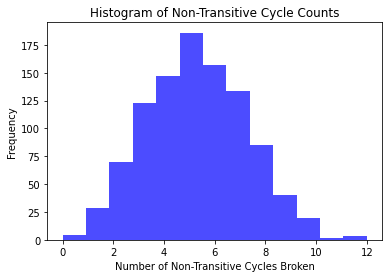

In [262]:
import random
import matplotlib.pyplot as plt

# Function to create a random directed graph
def create_random_directed_graph(vertices, edge_probability=0.5):
    edges = set()
    for i in range(len(vertices)):
        for j in range(len(vertices)):
            if i != j and random.random() < edge_probability:
                edges.add((vertices[i], vertices[j]))
    return edges

# DFS function for cycle detection
def dfs_cycle(vertex, graph, start_vertex, path, visited, cycles):
    if vertex == start_vertex and len(path) > 1:
        cycles.add(tuple(path))
        return

    if vertex in visited:
        return

    visited.add(vertex)
    path.append(vertex)

    for _, neighbor in filter(lambda edge: edge[0] == vertex, graph):
        dfs_cycle(neighbor, graph, start_vertex, path.copy(), visited.copy(), cycles)

# Function to detect and break cycles
def break_cycles(graph):
    cycles = set()
    for vertex, _ in graph:
        dfs_cycle(vertex, graph, vertex, [], set(), cycles)

    if not cycles:
        return 0

    # Remove a random edge from one of the detected cycles
    cycle = random.choice(list(cycles))
    cycle_edges = [(cycle[i], cycle[i + 1]) for i in range(len(cycle) - 1)]
    random_edge = random.choice(cycle_edges)
    graph.remove(random_edge)

    # Recursive call
    return 1 + break_cycles(graph)

# Loop to sample graphs and count the number of cycles broken
n = 5
k = 1
cycle_counts = []
num_graphs = 1000

theta = generate_additive_theta(n, 1)

vertices = theta # Example vertices
print(theta)
graphs = {}
for _ in range(num_graphs):
    graph = create_random_directed_graph([tuple(i) for i in theta], edge_probability = 0.6)
    g2 = list(graph)
    count = break_cycles(graph)
    graphs[count] = g2
    cycle_counts.append(count)

# Plotting the histogram of cycle counts
plt.hist(cycle_counts, bins=max(cycle_counts) - min(cycle_counts) + 1, alpha=0.7, color='blue')
plt.title('Histogram of Non-Transitive Cycle Counts')
plt.xlabel('Number of Non-Transitive Cycles Broken')
plt.ylabel('Frequency')
plt.show()



In [264]:
for k in graphs:
    print(f"{k}")

6
5
4
10
3
9
2
8
7
1
11
12
0


In [112]:
n = 3
m = 2**(n-1)
k = 1
sigma_weights = 10

theta = generate_additive_theta(n, k)
weights = generate_normal_weights(theta, sigma_weights)
alternatives = generate_random_alternatives_matrix(m, n)
ranks = compute_ws_ranks(alternatives, theta, weights)
t_sv = compute_semivalues(n, theta, weights, lambda x:1)
preferences = PreferenceModel(alternatives, ranks)
s = preferences.generate_sparse_preference_set()
print(s)

{((), (0, 2)), ((0, 1), (0, 2)), ((), (0, 1)), ((1,), (0, 2)), ((), (1,)), ((1,), (0, 1))}


In [304]:
import torch.optim as optim



def fit_model(model, theta, s, lamdba_1 = 0, lambda_2 = 0, lr=0.05, num_epochs = 200):
    optimizer = optim.Adam([model.weights], lr=lr)
    losses1 = []
    losses1.append(model.accuracy(s))
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()
        # Compute likelihood and prior
        likelihood = model.loglikelihood(s)
        # Loss is negative log-likelihood minus log-prior (for maximizing posterior)
        loss = -torch.log(likelihood) + model.logprior(lambda_1, lambda_2)
        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        losses1.append(model.accuracy(s))
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")
    #model.display_model()
    phi_params = [model.phi_function.phi_values[k] for k in model.phi_function.phi_values]
    optimizer = optim.Adam(phi_params, lr=lr)
    losses2 = []
    for epoch in range(num_epochs):
        total_loss = 0
        optimizer.zero_grad()
        # Compute likelihood and prior
        likelihood = model.loglikelihood(s)
        # Loss is negative log-likelihood minus log-prior (for maximizing posterior)
        loss = -torch.log(likelihood) + model.logprior(lambda_1, lambda_2)
        # Backpropagation
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        losses2.append(model.accuracy(s))
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}")
    return losses1, losses2

In [306]:
model = SSBModel(theta)

6: 0.75, 1.0


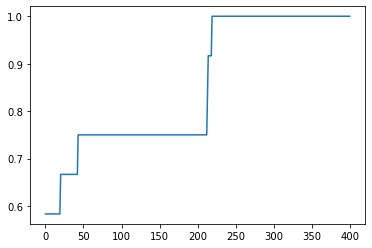

5: 0.6666666666666666, 1.0


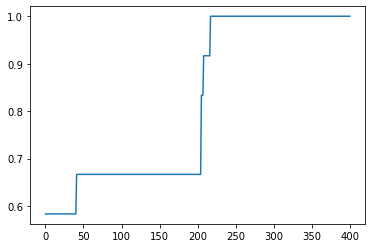

4: 0.6666666666666666, 1.0


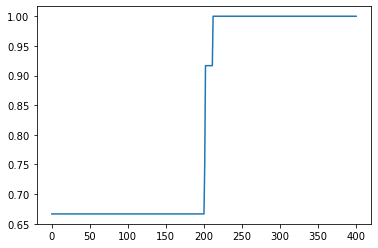

10: 0.5294117647058824, 1.0


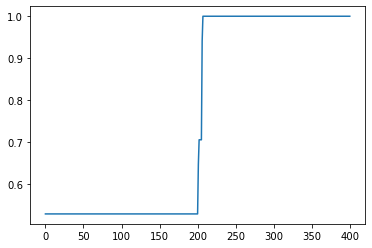

3: 0.7, 1.0


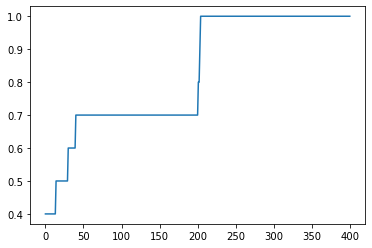

9: 0.625, 1.0


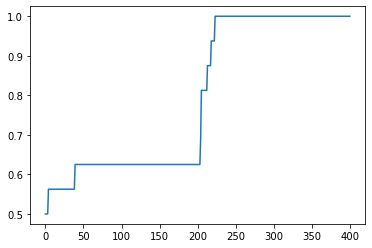

2: 0.7777777777777778, 1.0


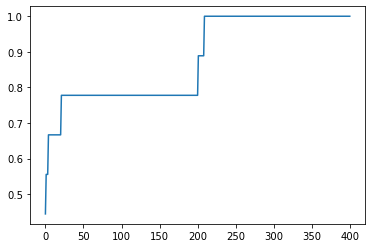

8: 0.6428571428571429, 1.0


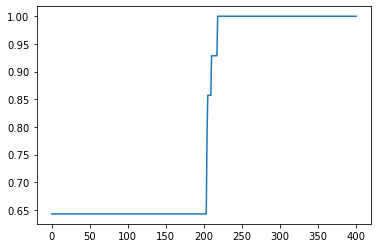

7: 0.6153846153846154, 1.0


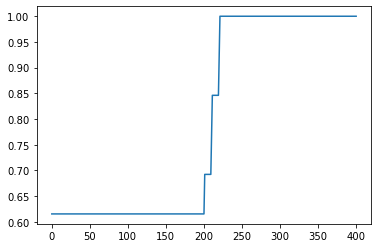

1: 0.8888888888888888, 1.0


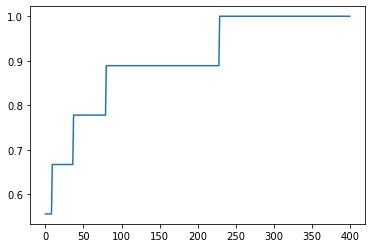

11: 0.625, 1.0


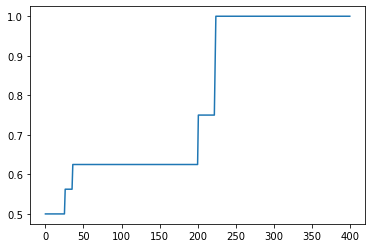

12: 0.5625, 1.0


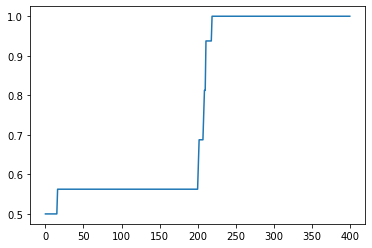

0: 1.0, 1.0


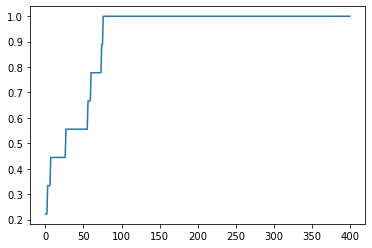

In [310]:
for k in graphs:
    model = SSBModel(theta)
    l1, l2 = fit_model(model, theta, graphs[k])
    print(f"{k}: {max(l1)}, {max(l2)}")
    l = l1+l2
    plt.plot(np.arange(len(l)), l)
    plt.show()

In [80]:
s

[[(0,), (1,)], [(1,), (2,)], [(0,), (2,)]]